In [2]:
import pandas as pd
import os
import numpy as np
import psycopg2
from dateutil.relativedelta import relativedelta
from psycopg2 import sql

## Database Connection String and Data Read

In [3]:
PGHOST = 'database-1.cdmxgirrcaa4.us-east-1.rds.amazonaws.com'
PGDATABASE = 'sonoma'
PGUSER = 'postgres'
PGPASSWORD = 'sonomacounty'

In [4]:
def connect():
    # Set up a connection
    conn_string = "host="+ PGHOST +" port="+ "5432" +" dbname="+ PGDATABASE +" user=" + PGUSER \
                  +" password="+ PGPASSWORD
    conn = psycopg2.connect(conn_string)
    print("Connected!")
    # Create a cursor object
    cursor = conn.cursor()
    return conn, cursor

In [5]:
conn, cursor = connect()

Connected!


In [6]:
query_animal_shelter = sql.SQL("""
SELECT * FROM Animal_Shelter_Intake_and_Outake;
""")

In [7]:
cur = conn.cursor()
cur.execute(query_animal_shelter)
animal_shelter_df = pd.DataFrame(cur.fetchall(), columns=['Name', 'Type','Breed','Color','Sex','Size','Date Of Birth',
                                                     'Impound Number','Kennel Number','Animal ID','Intake Date',
                                                     'Outcome Date','Days in Shelter','Intake Type','Intake Subtype',
                                                     'Outcome Type','Outcome Subtype','Intake Condition',
                                                     'Outcome Condition','Intake Jurisdiction','Outcome Jurisdiction',
                                                     'Outcome Zip Code','Location','Count'])
animal_shelter_df.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,None,CAT,SIAMESE,BLACK/BLACK,Female,KITTN,None,K22-042204,CS05,A412797,...,FIELD,TRANSFER,FORGOTTEN,TREATABLE/REHAB,TREATABLE/REHAB,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1
1,None,CAT,DOMESTIC SH,GRAY/WHITE,Male,KITTN,2022-06-24,K22-042194,CA03,A412786,...,PHONE,None,None,UNKNOWN,None,COUNTY,None,NaN,None,1
2,None,CAT,SIAMESE,GRAY/BLACK,Female,KITTN,None,K22-042201,CS05,A412794,...,FIELD,TRANSFER,FORGOTTEN,TREATABLE/REHAB,TREATABLE/REHAB,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1
3,None,CAT,SIAMESE,GRAY/BLACK,Female,KITTN,None,K22-042202,CS05,A412795,...,FIELD,TRANSFER,FORGOTTEN,TREATABLE/REHAB,TREATABLE/REHAB,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1
4,None,CAT,DOMESTIC SH,BLACK,Female,SMALL,2020-12-30,K22-041790,SMM,A412222,...,FIELD,TRANSFER,WE CARE,UNKNOWN,HEALTHY,COUNTY,OUT OF COUNTY,94574.0,"94574(38.525993, -122.432854)",1


## Machine Learning Data Preprocessing

In [8]:
# Data exploration
col_det_df = animal_shelter_df
columns_details_df = pd.DataFrame()
count = col_det_df.count()
null = col_det_df.isnull().sum()
unique = col_det_df.nunique()
dtype = col_det_df.dtypes
columns_details_df['count'] = count
columns_details_df['null'] = null
columns_details_df['unique'] = unique
columns_details_df['dtype'] = dtype
columns_details_df

,count,null,unique,dtype
Name,17291,6179,6319,object
Type,23470,0,3,object
Breed,23470,0,1005,object
Color,23470,0,332,object
Sex,23470,0,5,object
Size,23437,33,7,object
Date Of Birth,17618,5852,5442,object
Impound Number,23470,0,23470,object
Kennel Number,23462,8,161,object
Animal ID,23470,0,21200,object


In [10]:
# Animal type analysis
type_count = animal_shelter_df.groupby(["Type"]).count()
type_count

,Name,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
Type,,,,,,,,,,,,,,,,,,,,,
CAT,4822,8330,8330,8330,8328,6066,8330,8327,8330,8330,...,8330,8268,8177,8330,8150,8330,6797,6797,6797,8330
DOG,11874,13242,13242,13242,13211,10958,13242,13237,13242,13242,...,13242,13140,13029,13242,13035,13242,11994,11934,11934,13242
OTHER,595,1898,1898,1898,1898,594,1898,1898,1898,1898,...,1898,1872,1767,1898,1758,1898,1384,1371,1371,1898


In [12]:
# Filter columns
filtered_df = animal_shelter_df[['Type','Breed','Sex','Size','Date Of Birth','Intake Date',
                               'Days in Shelter','Intake Type','Intake Subtype',
                               'Outcome Type','Intake Condition','Intake Jurisdiction']]

# Filter Animal Type: 'CAT' and/or 'DOG'
# filtered_df = filtered_df[filtered_df['Type'] != "OTHER"]
filtered_df = filtered_df[filtered_df['Type'] == "CAT"]
# filtered_df = filtered_df[filtered_df['Type'] == "DOG"]

# Change column name
filtered_df = filtered_df.rename(columns={'Type': 'Animal Type'})

# Group Breed
filtered_df.loc[filtered_df['Breed'].str.contains('MIX'), 'Breed'] = 'MIX'
filtered_df.loc[filtered_df['Breed'].str.contains('/'), 'Breed'] = 'MIX'
filtered_df.loc[~filtered_df['Breed'].str.contains('MIX'), 'Breed'] = 'PURE'

# Group ML target classes
filtered_df['Outcome Type'].replace({'ADOPTION':'ADOPTION RETURN','RETURN TO OWNER':'ADOPTION RETURN'},inplace=True)

# Group other classes
filtered_df['Sex'].replace({'Spayed':'Spayed or Neutered','Neutered':'Spayed or Neutered'},inplace=True)
filtered_df['Intake Subtype'].replace({'BORN_HERE':'OTHER','COMM CAT':'OTHER','FIELD':'FIELD',
                                       'FIELD_OS':'FIELD','FIELD_RETURN TO OWNER':'FIELD','FLD_ABAND':'FIELD',
                                       'FLD_ARREST':'FIELD','FLD_CORONR':'FIELD','FLD_CRUEL':'FIELD',
                                       'FLD_EMERGE':'FIELD','FLD_EVICT':'FIELD','FLD_HOSPTL':'FIELD',
                                       'FLD_INVEST':'FIELD','FLD_LIVSTK':'FIELD','FLD_OWNED':'FIELD',
                                       'FLD_STRAY':'FIELD','MUN_SHELT':'OTHER','OVER THE COUNTER':'OVER THE COUNTER',
                                       'OVER THE COUNTER_ARREST':'OVER THE COUNTER','OVER THE COUNTER_CORONR':'OVER THE COUNTER','OVER THE COUNTER_EVICT':'OVER THE COUNTER',
                                       'OVER THE COUNTER_OS':'OVER THE COUNTER','OVER THE COUNTER_OWNED':'OVER THE COUNTER','OVER THE COUNTER_RETURN TO OWNER':'OVER THE COUNTER',
                                       'OVER THE COUNTER_STRAY':'OVER THE COUNTER','PHONE':'OTHER','PRIV_SHELT':'OTHER',
                                       'RESCUE_GRP':'OTHER','VET_HOSP':'OTHER'
                                      },inplace=True)
# Drop NaN
filtered_df = filtered_df.dropna()

# Change dates dtype
filtered_df[['Date Of Birth','Intake Date']] = filtered_df[['Date Of Birth','Intake Date']].apply(pd.to_datetime)

# Calculate 'Age at intake time' and drop
filtered_df['Age at Intake'] = filtered_df['Intake Date'] - filtered_df['Date Of Birth']
filtered_df['Age at Intake'] = filtered_df['Age at Intake']/np.timedelta64(1, 'Y')

# Remove negative values in 'Age at intake time'
filtered_df = filtered_df[filtered_df['Age at Intake'] > 0]

# Change 'Days in shelter' dtype and format
# filtered_df['Days in Shelter'] = filtered_df['Days in Shelter'].str.replace(',', '').astype(float)

# Drop days in shelter = 0
filtered_df = filtered_df[filtered_df['Days in Shelter'] > 0]
filtered_df.head()

,Animal Type,Breed,Sex,Size,Date Of Birth,Intake Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Intake Condition,Intake Jurisdiction,Age at Intake
4,CAT,PURE,Female,SMALL,2020-12-30,2022-06-30,41,STRAY,FIELD,TRANSFER,UNKNOWN,COUNTY,1.497635
6,CAT,PURE,Male,SMALL,2015-08-03,2022-08-03,6,STRAY,OVER THE COUNTER,TRANSFER,UNKNOWN,SANTA ROSA,7.000828
59,CAT,PURE,Male,SMALL,2021-08-09,2022-08-09,3,STRAY,FIELD,EUTHANIZE,UNKNOWN,COUNTY,0.999336
72,CAT,MIX,Spayed or Neutered,SMALL,2002-08-09,2022-08-09,3,OWNER SURRENDER,FIELD,EUTHANIZE,UNKNOWN,SANTA ROSA,20.000411
92,CAT,PURE,Spayed or Neutered,SMALL,2022-05-06,2022-07-06,38,CONFISCATE,FIELD,ADOPTION RETURN,HEALTHY,SANTA ROSA,0.167012


In [13]:
# Drop dates columns
filtered_df = filtered_df.drop('Date Of Birth', axis=1)
filtered_df = filtered_df.drop('Intake Date', axis=1)
filtered_df.head()

,Animal Type,Breed,Sex,Size,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Intake Condition,Intake Jurisdiction,Age at Intake
4,CAT,PURE,Female,SMALL,41,STRAY,FIELD,TRANSFER,UNKNOWN,COUNTY,1.497635
6,CAT,PURE,Male,SMALL,6,STRAY,OVER THE COUNTER,TRANSFER,UNKNOWN,SANTA ROSA,7.000828
59,CAT,PURE,Male,SMALL,3,STRAY,FIELD,EUTHANIZE,UNKNOWN,COUNTY,0.999336
72,CAT,MIX,Spayed or Neutered,SMALL,3,OWNER SURRENDER,FIELD,EUTHANIZE,UNKNOWN,SANTA ROSA,20.000411
92,CAT,PURE,Spayed or Neutered,SMALL,38,CONFISCATE,FIELD,ADOPTION RETURN,HEALTHY,SANTA ROSA,0.167012


In [14]:
# Data analysis
col_det_df = filtered_df
cleaned_columns_details_df = pd.DataFrame()
count = col_det_df.count()
null = col_det_df.isnull().sum()
unique = col_det_df.nunique()
dtype = col_det_df.dtypes
cleaned_columns_details_df['count'] = count
cleaned_columns_details_df['null'] = null
cleaned_columns_details_df['unique'] = unique
cleaned_columns_details_df['dtype'] = dtype
cleaned_columns_details_df

,count,null,unique,dtype
Animal Type,5327,0,1,object
Breed,5327,0,2,object
Sex,5327,0,4,object
Size,5327,0,6,object
Days in Shelter,5327,0,138,int64
Intake Type,5327,0,6,object
Intake Subtype,5327,0,3,object
Outcome Type,5327,0,7,object
Intake Condition,5327,0,5,object
Intake Jurisdiction,5327,0,12,object


In [15]:
# Generate a categorical variable list
filtered_df_cat = filtered_df.dtypes[filtered_df.dtypes == "object"].index.tolist()
filtered_df_cat

['Animal Type',
 'Breed',
 'Sex',
 'Size',
 'Intake Type',
 'Intake Subtype',
 'Outcome Type',
 'Intake Condition',
 'Intake Jurisdiction']

In [16]:
# Check the number of unique values in each column
filtered_df[filtered_df_cat].nunique()

Animal Type             1
Breed                   2
Sex                     4
Size                    6
Intake Type             6
Intake Subtype          3
Outcome Type            7
Intake Condition        5
Intake Jurisdiction    12
dtype: int64

In [17]:
from sklearn.preprocessing import OneHotEncoder
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(filtered_df[filtered_df_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(filtered_df_cat)
encode_df.head()

,Animal Type_CAT,Breed_MIX,Breed_PURE,Sex_Female,Sex_Male,Sex_Spayed or Neutered,Sex_Unknown,Size_KITTN,Size_LARGE,Size_MED,...,Intake Jurisdiction_*HEALDSBURG,Intake Jurisdiction_*PETALUMA,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
# Merge one-hot encoded features and drop the originals
filtered_df = filtered_df.merge(encode_df,left_index=True, right_index=True)
filtered_encoded_df = filtered_df.drop(filtered_df_cat,1)
filtered_encoded_df.head()

C:\Users\fernanm\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Days in Shelter,Age at Intake,Animal Type_CAT,Breed_MIX,Breed_PURE,Sex_Female,Sex_Male,Sex_Spayed or Neutered,Sex_Unknown,Size_KITTN,...,Intake Jurisdiction_*HEALDSBURG,Intake Jurisdiction_*PETALUMA,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN
4,41,1.497635,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,6,7.000828,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
59,3,0.999336,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
72,3,20.000411,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
92,38,0.167012,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
filtered_encoded_df.columns

Index(['Days in Shelter', 'Age at Intake', 'Animal Type_CAT', 'Breed_MIX',
       'Breed_PURE', 'Sex_Female', 'Sex_Male', 'Sex_Spayed or Neutered',
       'Sex_Unknown', 'Size_KITTN', 'Size_LARGE', 'Size_MED', 'Size_SMALL',
       'Size_TOY', 'Size_X-LRG', 'Intake Type_ADOPTION RETURN',
       'Intake Type_CONFISCATE', 'Intake Type_OWNER SURRENDER',
       'Intake Type_QUARANTINE', 'Intake Type_STRAY', 'Intake Type_TRANSFER',
       'Intake Subtype_FIELD', 'Intake Subtype_OTHER',
       'Intake Subtype_OVER THE COUNTER', 'Outcome Type_ADOPTION RETURN',
       'Outcome Type_DIED', 'Outcome Type_DISPOSAL',
       'Outcome Type_ESCAPED/STOLEN', 'Outcome Type_EUTHANIZE',
       'Outcome Type_RTOS', 'Outcome Type_TRANSFER',
       'Intake Condition_HEALTHY', 'Intake Condition_TREATABLE/MANAGEABLE',
       'Intake Condition_TREATABLE/REHAB', 'Intake Condition_UNKNOWN',
       'Intake Condition_UNTREATABLE', 'Intake Jurisdiction_*CLOVERDALE',
       'Intake Jurisdiction_*COTATI', 'Intake Juri

In [20]:
# Drop other outcome types
filtered_encoded_df = filtered_encoded_df.drop(['Outcome Type_DIED','Outcome Type_DISPOSAL',
                                                'Outcome Type_ESCAPED/STOLEN','Outcome Type_EUTHANIZE',
                                                'Outcome Type_RTOS','Outcome Type_TRANSFER'], axis=1)


# filtered_encoded_df = filtered_encoded_df.drop(['Outcome Type_DIED','Outcome Type_DISPOSAL','Outcome Type_RETURN TO OWNER',
#                                                 'Outcome Type_ESCAPED/STOLEN','Outcome Type_EUTHANIZE',
#                                                 'Outcome Type_RTOS','Outcome Type_TRANSFER'], axis=1)

# Drop other columns to avoid multicollinearity
filtered_encoded_df = filtered_encoded_df.drop(['Breed_PURE'], axis=1)
filtered_encoded_df = filtered_encoded_df.drop(['Sex_Female','Sex_Male','Sex_Unknown'], axis=1)

In [21]:
# Copy columns to be scaled
scale_df = filtered_encoded_df[['Days in Shelter', 'Age at Intake']].copy()
scale_df.head()

,Days in Shelter,Age at Intake
4,41,1.497635
6,6,7.000828
59,3,0.999336
72,3,20.000411
92,38,0.167012


In [22]:
# Describe columns to be scaled
scale_df.describe()

,Days in Shelter,Age at Intake
count,1208.000000,1208.000000
mean,23.386589,2.266259
std,23.334186,3.779127
min,1.000000,0.002738
25%,7.000000,0.167012
50%,16.000000,0.317597
75%,33.000000,2.373765
max,258.000000,20.000411


In [23]:
# Create the Scaler instance
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
# scaler = RobustScaler()
scaler = StandardScaler()

In [24]:
# Fit the Scaler
scaler.fit(scale_df)

StandardScaler()

In [25]:
# Scale the data
scaled_data = scaler.transform(scale_df)

In [26]:
# Create a DataFrame with the scaled data
transformed_scaled_data = pd.DataFrame(scaled_data, index=scale_df.index, columns=scale_df.columns)
transformed_scaled_data.head()

,Days in Shelter,Age at Intake
4,0.755146,-0.203471
6,-0.745421,1.253340
59,-0.874041,-0.335381
72,-0.874041,4.694602
92,0.626526,-0.555715


In [27]:
filtered_encoded_scaled_df = filtered_encoded_df.merge(transformed_scaled_data, how = 'outer', 
                                                left_index = True, right_index = True)
filtered_encoded_scaled_df.head()

,Days in Shelter_x,Age at Intake_x,Animal Type_CAT,Breed_MIX,Sex_Spayed or Neutered,Size_KITTN,Size_LARGE,Size_MED,Size_SMALL,Size_TOY,...,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
4,41,1.497635,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.755146,-0.203471
6,6,7.000828,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.745421,1.253340
59,3,0.999336,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874041,-0.335381
72,3,20.000411,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874041,4.694602
92,38,0.167012,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.626526,-0.555715


In [28]:
filtered_encoded_scaled_df = filtered_encoded_scaled_df.drop(['Days in Shelter_x','Age at Intake_x'], axis=1)
filtered_encoded_scaled_df.head()

,Animal Type_CAT,Breed_MIX,Sex_Spayed or Neutered,Size_KITTN,Size_LARGE,Size_MED,Size_SMALL,Size_TOY,Size_X-LRG,Intake Type_ADOPTION RETURN,...,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.755146,-0.203471
6,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.745421,1.253340
59,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874041,-0.335381
72,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874041,4.694602
92,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.626526,-0.555715


In [29]:
# Export CSV or create testing df
# filtered_encoded_scaled_df.to_csv('sonoma_shelter_ML_test.csv',index=False)
df = filtered_encoded_scaled_df.copy()
df = df.reset_index(drop=True)
df.head(5)

,Animal Type_CAT,Breed_MIX,Sex_Spayed or Neutered,Size_KITTN,Size_LARGE,Size_MED,Size_SMALL,Size_TOY,Size_X-LRG,Intake Type_ADOPTION RETURN,...,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.755146,-0.203471
1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.745421,1.253340
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874041,-0.335381
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874041,4.694602
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.626526,-0.555715


## PyCaret

In [30]:
import pycaret
from pycaret.regression import *

In [31]:
data = df.sample(frac=0.9, random_state=786).reset_index(drop=True)
data_unseen = df.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1087, 38)
Unseen Data For Predictions: (121, 38)


In [32]:
# exp_reg101 = setup(data = df,
#                    target = 'Outcome Type_ADOPTION RETURN',
#                    ignore_features = ['listing image','listing url','full address','zipcode']) 

exp_reg101 = setup(data = df,
                    target = 'Outcome Type_ADOPTION RETURN')

# # exp_reg101 = setup(data = df,
#                    target = 'Outcome Type_ADOPTION')

,Description,Value
0,session_id,5896
1,Target,Outcome Type_ADOPTION RETURN
2,Original Data,"(1208, 38)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,29
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(845, 37)"


In [33]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.1865,0.0940,0.3036,0.5217,0.0000,0.1283,0.0220
br,Bayesian Ridge,0.2222,0.1039,0.3196,0.4718,0.0000,0.1397,0.0060
ridge,Ridge Regression,0.2210,0.1046,0.3204,0.4687,0.0000,0.1380,0.0050
lr,Linear Regression,0.2207,0.1057,0.3221,0.4627,0.0000,0.1375,0.4410
rf,Random Forest Regressor,0.1891,0.1075,0.3252,0.4521,0.0000,0.1348,0.1650
omp,Orthogonal Matching Pursuit,0.2311,0.1081,0.3259,0.4510,0.0000,0.1416,0.0050
ada,AdaBoost Regressor,0.2417,0.1089,0.3281,0.4467,0.0000,0.2076,0.0100
huber,Huber Regressor,0.1531,0.1308,0.3561,0.3382,0.0000,0.0312,0.0140
et,Extra Trees Regressor,0.1861,0.1325,0.3620,0.3286,0.0000,0.1373,0.1520
par,Passive Aggressive Regressor,0.2907,0.1575,0.3900,0.2052,0.0000,0.2167,0.0070


In [34]:
model = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1734,0.0850,0.2915,0.6079,-0.0000,0.1085
1,0.2226,0.1156,0.3400,0.4295,-0.0000,0.1474
2,0.1874,0.0918,0.3031,0.5576,-0.0000,0.1552
3,0.1960,0.0944,0.3073,0.4924,-0.0000,0.1602
4,0.1840,0.0910,0.3016,0.5716,-0.0000,0.1043
5,0.1701,0.0786,0.2803,0.5334,-0.0000,0.1172
6,0.2038,0.1160,0.3407,0.4570,-0.0000,0.1178
7,0.1380,0.0464,0.2155,0.7439,-0.0000,0.1106
8,0.1575,0.0730,0.2702,0.6423,-0.0000,0.1123


In [35]:
tuned_gbr = tune_model(model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1935,0.0867,0.2945,0.5999,-0.0000,0.1209
1,0.2251,0.1116,0.3341,0.4491,-0.0000,0.1466
2,0.1997,0.0935,0.3057,0.5498,-0.0000,0.1478
3,0.1907,0.0893,0.2989,0.5198,-0.0000,0.1586
4,0.1965,0.0991,0.3148,0.5332,-0.0000,0.1049
5,0.1706,0.0758,0.2753,0.5499,-0.0000,0.1183
6,0.2006,0.1136,0.3371,0.4684,-0.0000,0.1088
7,0.1470,0.0413,0.2032,0.7723,-0.0000,0.1168
8,0.1854,0.0859,0.2931,0.5791,-0.0000,0.1283


In [29]:
# plot_model(tuned_gbr)

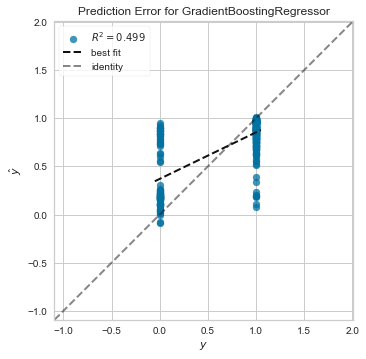

In [36]:
plot_model(tuned_gbr, plot = 'error')

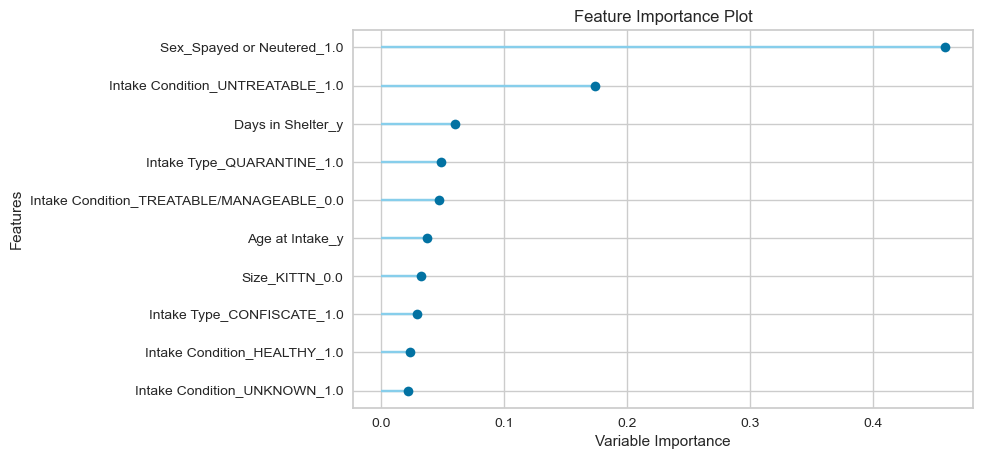

In [37]:
plot_model(tuned_gbr, plot='feature')

In [38]:
evaluate_model(tuned_gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [39]:
unseen_predictions = predict_model(tuned_gbr, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1714,0.0668,0.2585,0.6244,0.1784,0.1340


,Animal Type_CAT,Breed_MIX,Sex_Spayed or Neutered,Size_KITTN,Size_LARGE,Size_MED,Size_SMALL,Size_TOY,Size_X-LRG,Intake Type_ADOPTION RETURN,...,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y,Label
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.788294,-0.599202,0.857411
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.788294,-0.511503,0.730632
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.445308,2.832639,0.053402
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.488181,-0.071561,0.175134
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.058657,0.071946,0.991851


In [34]:
# unseen_predictions.to_csv('predictions.csv',index=False)
# unseen_predictions.to_csv('adoptions.csv',index=False)

## Gradient Boosting Regressor

#### Define features and Split the Data into Training and Testing

In [40]:
# Define features
X = df.copy()
X = X.drop('Outcome Type_ADOPTION RETURN', axis=1)
# X = X.drop('Outcome Type_ADOPTION', axis=1)
X.head()
# Create our target
y = df['Outcome Type_ADOPTION RETURN']
# y = df['Outcome Type_ADOPTION']

In [41]:
X.describe()

,Animal Type_CAT,Breed_MIX,Sex_Spayed or Neutered,Size_KITTN,Size_LARGE,Size_MED,Size_SMALL,Size_TOY,Size_X-LRG,Intake Type_ADOPTION RETURN,...,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
count,1208.0,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.0,1208.0,1208.000000,...,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.0,1.208000e+03,1.208000e+03
mean,1.0,0.023179,0.846854,0.484272,0.009934,0.015728,0.490066,0.0,0.0,0.019040,...,0.006623,0.001656,0.000828,0.056291,0.442881,0.010762,0.473510,0.0,6.433412e-19,-6.010645e-17
std,0.0,0.150533,0.360277,0.499960,0.099213,0.124475,0.500108,0.0,0.0,0.136721,...,0.081143,0.040673,0.028772,0.230579,0.496932,0.103221,0.499505,0.0,1.000414e+00,1.000414e+00
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-9.597876e-01,-5.992017e-01
25%,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-7.025476e-01,-5.557148e-01
50%,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-3.166877e-01,-5.158518e-01
75%,1.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,4.121589e-01,2.845907e-02
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.005866e+01,4.694602e+00


In [42]:
# Check the balance of our target values
y.value_counts()

1.0    882
0.0    326
Name: Outcome Type_ADOPTION RETURN, dtype: int64

In [43]:
# Split the Data into Training and Testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
X_train.shape

(906, 37)

#### Run GBR

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
# Test model parameters and loop learning rates
# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    regressor = GradientBoostingRegressor(n_estimators=100,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            criterion = 'mse',
                                            random_state=0)
    # Fit the model
    regressor.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        regressor.score(
            X_train,
            y_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        regressor.score(
            X_test,
            y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.591
Accuracy score (validation): 0.479

Learning rate:  0.1
Accuracy score (training): 0.645
Accuracy score (validation): 0.485

Learning rate:  0.25
Accuracy score (training): 0.709
Accuracy score (validation): 0.484

Learning rate:  0.5
Accuracy score (training): 0.751
Accuracy score (validation): 0.435

Learning rate:  0.75
Accuracy score (training): 0.764
Accuracy score (validation): 0.381

Learning rate:  1
Accuracy score (training): 0.794
Accuracy score (validation): 0.363



In [45]:
# Choose parameters and create regessor
regressor_params = {'n_estimators': 100,
                    'learning_rate': 0.25,
                    'max_features': 5,
                    'max_depth': 3,
                    'criterion': 'mse',
                    'random_state': 0}

regressor = GradientBoostingRegressor(**regressor_params)
# Fit the model
regressor.fit(X_train, y_train)
# Make Prediction
predictions = regressor.predict(X_test)
# predictions

#### Evaluate model

In [46]:
# Print Coefficient of determination R2
print("Model Accuracy: %.3f" % regressor.score(X_test, y_test))
# Print the mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, regressor.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy: 0.484
The mean squared error (MSE) on test set: 0.1012


In [47]:
# Sort the features by their importance
features_imp_df = pd.DataFrame(sorted(zip(regressor.feature_importances_, X.columns), reverse=True))
features_imp_df.columns = ['%', 'Feature']
features_imp_df.head(10).style.format({'%': '{:,.1%}'})

,%,Feature
0,43.8%,Sex_Spayed or Neutered
1,13.8%,Intake Condition_UNTREATABLE
2,11.7%,Intake Condition_HEALTHY
3,5.6%,Age at Intake_y
4,4.5%,Days in Shelter_y
5,3.4%,Size_KITTN
6,2.4%,Intake Condition_UNKNOWN
7,2.3%,Size_SMALL
8,1.7%,Intake Type_STRAY
9,1.2%,Intake Subtype_OVER THE COUNTER


In [48]:
# Label manual analysis
pred_df = pd.DataFrame(predictions)
pred_df.columns=['Label']
target_df = pd.DataFrame(y_test).reset_index(drop=True)
target_df.columns=['Target']
label_analysis_df = target_df.merge(pred_df, how = 'outer', left_index = True, right_index = True)
label_analysis_df['Row Count'] = 1
label_analysis_df.head()

,Target,Label,Row Count
0,1.0,1.033978,1
1,0.0,-0.011411,1
2,1.0,0.844780,1
3,1.0,0.871248,1
4,0.0,0.825283,1


In [49]:
label_summary = label_analysis_df.groupby(["Target"]).sum()
label_summary['%'] = label_summary['Label'] / label_summary['Row Count']
label_summary.style.format({
    'Label': '{:,.2f}',
    'Row Count': '{:,.2f}',
    '%': '{:,.2%}',
})

,Label,Row Count,%
Target,,,
0.0,27.53,81.00,33.99%
1.0,195.19,221.00,88.32%


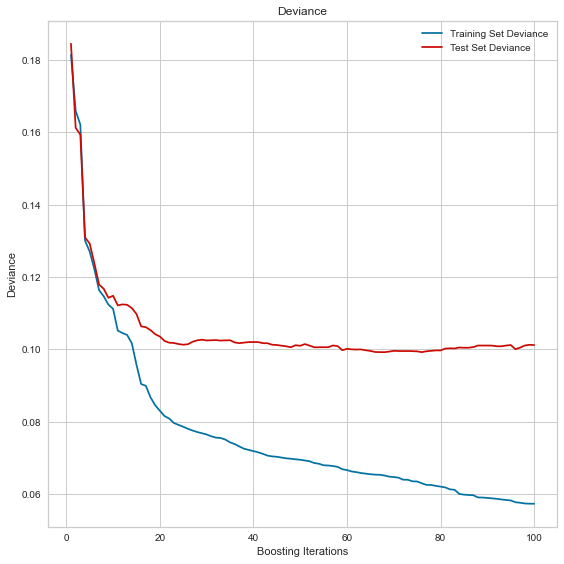

In [50]:
from matplotlib import pyplot as plt
# Assessing the training and test deviance (loss)
test_score = np.zeros((regressor_params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(regressor.staged_predict(X_test)):
    test_score[i] = regressor.loss_(y_test, y_pred)
 
fig = plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(regressor_params['n_estimators']) + 1, regressor.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(regressor_params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()